In [2]:
%matplotlib inline

from scrape_scholar import *
import sqlite3 
import pandas as pd

import numpy as np
import networkx as nx
import altair as alt
import nx_altair as nxa
alt.renderers.enable('notebook')

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pylab

## Arrumando o input

In [3]:
# Conectando ao db
conn = sqlite3.connect('db.db')
cur = conn.cursor()

# Criando as tables    
cur.executescript('''
DROP TABLE IF EXISTS author;
DROP TABLE IF EXISTS paper;
DROP TABLE IF EXISTS author_paper;

CREATE TABLE author(
id INTEGER PRIMARY KEY NOT NULL,
author TEXT NOT NULL UNIQUE);
CREATE TABLE paper(
id INTEGER PRIMARY KEY NOT NULL,
paper VARCHAT NOT NULL UNIQUE);
''')

conn.commit()
conn.close()

def scrape_and_store(author_name):

    conn = sqlite3.connect("db.db")
    cur = conn.cursor()
    
    # Coletando os dados
    data = scrape(author_name)

    # Inserindo nas tables paper e author
    for paper in range(len(data)):
        conn.execute("INSERT OR IGNORE INTO paper (paper) VALUES (?)", [data[paper].get('title')])
        for author in data[paper].get('authors'):
            conn.execute("INSERT OR IGNORE INTO author (author) VALUES (?)", [author])
        
    # Inserindo na author_paper
    # tem algum jeito mais eficiente?    
    author_paper = pd.DataFrame(columns = ["paper", "author"])
    
    for paper in range(len(data)):
        for author in data[paper].get('authors'):
            author_paper = author_paper.append({"paper" : data[paper].get('title'), 'author' : author}, ignore_index = True)
        
    aux_paper = []
    cur.execute("SELECT * FROM paper")
    aux_paper = cur.fetchall()
    aux_paper = pd.DataFrame(aux_paper, columns = ["paper_id", "paper"])

    aux_author = []
    cur.execute("SELECT * FROM author")
    aux_author = cur.fetchall()
    aux_author = pd.DataFrame(aux_author, columns = ['author_id', 'author'])

    author_paper = pd.merge(pd.merge(author_paper, aux_author), aux_paper)
    author_paper.to_sql("author_paper", con = conn, if_exists = "append")

    conn.commit()
    conn.close()

In [4]:
scrape_and_store("Rodrigo Targino")
conn = sqlite3.connect('db.db')
cur = conn.cursor()
inpt = pd.read_sql("SELECT * FROM author_paper", conn)
conn.close()

## Parte do NetworkX

## Funções pros gráficos

In [5]:
def plot_authors():
    
    conn = sqlite3.connect('db.db')
    cur = conn.cursor()
    inpt = pd.read_sql("SELECT * FROM author_paper", conn)
    conn.close()
    
    inpt = inpt[['paper', 'author']]
    inpt['values'] = 1
    
    lst = list(inpt['author'])
    names = sorted(list(set(lst)))

    inpt = inpt.pivot_table(index = 'paper', columns = 'author').fillna(0)
    inpt.index.name = None

    cols = inpt.columns
    X = sp.csr_matrix(inpt.astype(int).values)
    Xc = X.T * X  
    Xc.setdiag(0)  

    inpt = pd.DataFrame(Xc.todense(), index = cols, columns=cols)
    graph = nx.from_numpy_matrix(inpt.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(names)))
    
    cont = 0
    for n in graph.nodes():
        graph.nodes[n]['author'] = names[cont]
        cont += 1
    
    nxa.draw_networkx(G = graph, pos = nx.spring_layout(graph), node_tooltip = ['author']).interactive()
    limits = pylab.axis('off')  

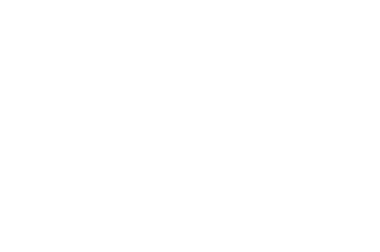

In [6]:
conn = sqlite3.connect('db.db')
cur = conn.cursor()
inpt = pd.read_sql("SELECT * FROM author_paper", conn)
conn.close()

inpt = inpt[['paper', 'author']]
inpt['values'] = 1

lst = list(inpt['author'])
names = sorted(list(set(lst)))

inpt = inpt.pivot_table(index = 'paper', columns = 'author').fillna(0)
inpt.index.name = None

cols = inpt.columns
X = sp.csr_matrix(inpt.astype(int).values)
Xc = X.T * X  
Xc.setdiag(0)  

inpt = pd.DataFrame(Xc.todense(), index = cols, columns=cols)
graph = nx.from_numpy_matrix(inpt.values)
graph = nx.relabel_nodes(graph, dict(enumerate(names)))

cont = 0
for n in graph.nodes():
    graph.nodes[n]['author'] = names[cont]
    cont += 1

pos = nx.spring_layout(graph)    
    
nxa.draw_networkx(G = graph, pos = pos, node_tooltip = ['author']).interactive()
limits = pylab.axis('off')  


In [7]:
graph

In [ ]:
plot_authors()

In [ ]:
def plot_papers():
    
    conn = sqlite3.connect('db.db')
    cur = conn.cursor()
    inpt = pd.read_sql("SELECT * FROM author_paper", conn)
    conn.close()
    
    inpt = inpt[['paper', 'author']]
    inpt['values'] = 1
    inpt
    
    lst = list(inpt['paper'])
    names = sorted(list(set(lst)))

    inpt = inpt.pivot_table(index = 'author', columns = 'paper').fillna(0)
    inpt.index.name = None

    cols = inpt.columns
    X = sp.csr_matrix(inpt.astype(int).values)
    Xc = X.T * X  
    Xc.setdiag(0)  

    inpt = pd.DataFrame(Xc.todense(), index = cols, columns=cols)
    graph = nx.from_numpy_matrix(inpt.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(names)))

    nx.draw_networkx(graph, with_labels = True)
    limits = pylab.axis('off')  

In [ ]:
plot_papers()